<a href="https://colab.research.google.com/github/rafiag/DTI2020/blob/main/006_Clustering_Mall_Customer_Segmentation_(Assignment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Clustering is a Machine Learning technique that involves the grouping of data points. Given a set of data points, we can use a clustering algorithm to classify each data point into a specific group. In theory, data points that are in the same group should have similar properties and/or features, while data points in different groups should have highly dissimilar properties and/or features. Clustering is a method of unsupervised learning and is a common technique for statistical data analysis used in many fields.

In this notebook we will use the Mall Customer dataset to build a model to group customer based on their characteristic. We wiill try to build 2 models using different algorithm K-Means and Agglomerative Hierarchical Clustering. After building each model we will evalueate them and compare which model are the best for our case. We will then try to understand and extract any insight from the clustering result. Lastly, we will save the clustering result to our original dataset and then also save our model for reussability.

To start we will load some basic libraries such as Pandas and NumPy and then make some configuration to some of those libraries.

In [1]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')
sns.set(rc={'figure.facecolor':'white'})
sns.set_palette('Accent')

# Data Pre-Processing

Before we can begin to create our first model we first need to load and pre-process. This step ensure that our model will receive a good data to learn from, as they said "a model is only as good as it's data". The data pre-processing will be divided into few steps as explained below.

## Loading Data

In this first step we will load our dataset that has been uploaded on my GitHub for easier process. Below are the list of the column in our dataset:

1. Gender (categoric: male, female)
2. Age (numeric)
3. Annual Income in k$ (numeric)
4. Spending Score (numeric: 1-100)

Our dataset also include a unique 'CustomerID' for each row, we will drop this column because it won't be used in our clustering algorithm. 

In [2]:
# Load dataset and drop the CustomerID column
df_mall = (pd.read_csv('https://raw.githubusercontent.com/rafiag/DTI2020/main/data/Mall_Customers.csv')
             .drop('CustomerID', axis=1))


# print(df_mall.info())
print('Shape of dataframe:', df_mall.shape)
df_mall.head()

Shape of dataframe: (200, 4)


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Missing Values

To start we need to check if there is any missing values in our data. In some case our data might have missing values in some column, this can be caused some reasons such as human error. We can use the `is_null()` function from Pandas to check for any missing data and then use the `sum()` function to see the total of missing values in each column.

In [3]:
df_mall.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

From the result we can be assured that our data have no missing value and are good to go. In the case where you did have missing value in your data you can solve it by doing imputation or just remove the column altogether depending on your case. [Here](https://www.kaggle.com/dansbecker/handling-missing-values) is a good Kaggle course on how to handle missing value in dataset.

## Scale Numeric Data

Next up, we will scale our numerical data to avoid outlier presence that can significantly affect our model. Using `StandardScaler()` function from sklearn we can scale each our columns that contains numerical data. The scaling will be done using the formula below:

<div align="center">$Z = \frac{X - U}{S}$</div>

*Where:*

*$Z:$ scaled value*

*$X:$ original value*

*$U:$ mean of the data*

*$S:$ standard deviation of the data*

In [4]:
from sklearn.preprocessing import StandardScaler

# Copying original dataframe
df_mall_ready = df_mall.copy()

scaler = StandardScaler()
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df_mall_ready[num_cols] = scaler.fit_transform(df_mall_ready[num_cols])

df_mall_ready.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,-1.424569,-1.738999,-0.434801
1,Male,-1.281035,-1.738999,1.195704
2,Female,-1.352802,-1.700830,-1.715913
3,Female,-1.137502,-1.700830,1.040418
4,Female,-0.563369,-1.662660,-0.395980


## Encode Categorical Value

Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use `OneHotEncoder()` provided by sklearn. Basically it will transform a categorical column from this:

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| divorced | yes     |

...into something like this...

| marital_single | marital_divorced | housing_yes | housing_no |
|----------------|------------------|-------------|------------|
| 1              | 0                | 1           | 0          |
| 0              | 1                | 0           | 1          |
| 0              | 1                | 1           | 0          |


In [5]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
cat_cols = ['Gender']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_mall_ready[cat_cols]))
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_mall_ready = df_mall_ready.drop(cat_cols ,axis=1)
df_mall_ready = pd.concat([df_encoded, df_mall_ready], axis=1)

print('Shape of dataframe:', df_mall_ready.shape)
df_mall_ready.head()

Shape of dataframe: (200, 5)


,Gender_Female,Gender_Male,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,1.0,-1.424569,-1.738999,-0.434801
1,0.0,1.0,-1.281035,-1.738999,1.195704
2,1.0,0.0,-1.352802,-1.700830,-1.715913
3,1.0,0.0,-1.137502,-1.700830,1.040418
4,1.0,0.0,-0.563369,-1.662660,-0.395980


## Data Exploration

Before starting to build our model it's a good practice to always do initial data exploration. It will help us understand our data better and can help us decide which feature to use when building our model. Here, we will try to see the relationship between each column in the data by using the `pairplot()` function from Seaborn to draw a histogram and scatter plot of every combination between all the column we have.

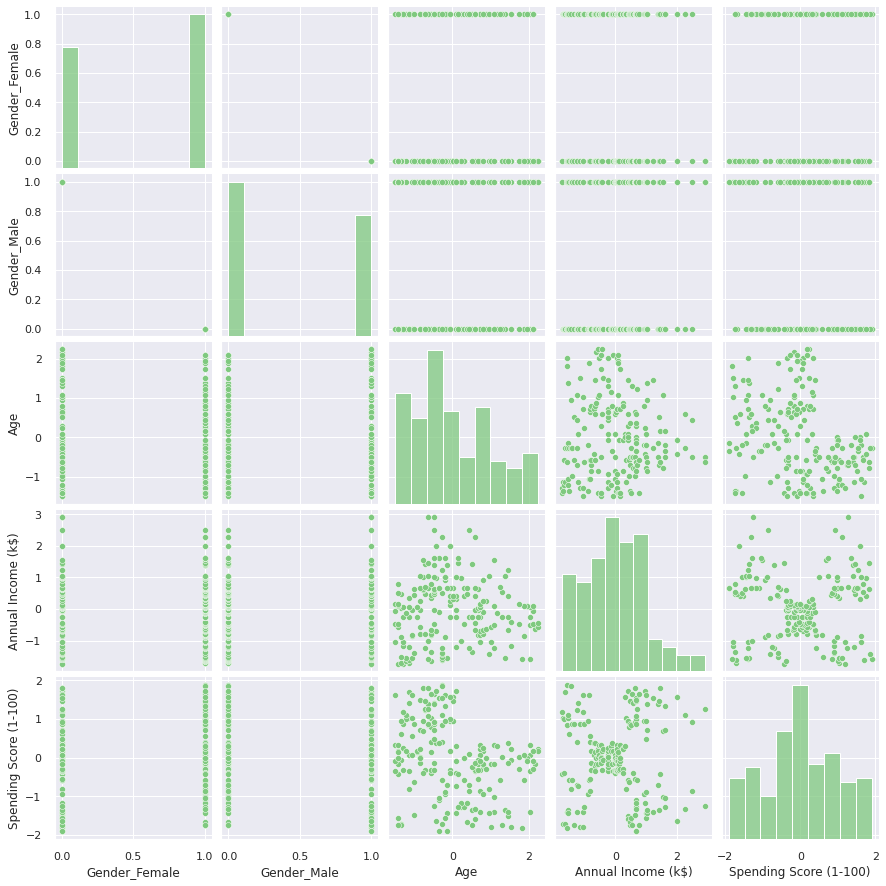

In [6]:
# Draw pair plot of scatter and histogram
sns.pairplot(data=df_mall_ready)

From the plot above we can see that there is clear cluster formed on the scatter plot between spending score, age, and annual income.

## Feature Selection

From our previous result we can select those 3 column as our feature and exclude the gender column.

In [7]:
feature = df_mall_ready[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
feature.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


# Modeling

After making sure our data is good and ready we can continue to building our model. In this notebook we will try to build 2 different models with different algorithm then we will evaluate each model to decide which model works best for our data.

To evaluate our model we will use the silhouette coefficient calculated as below:

<div align='center'>
$ s(i) = \frac{b-a}{max(a, b)} $
</div>

*where:\
$a =$ mean intra-cluster distance\
$b =$ distance between a sample and the nearest cluster that the sample is not a part of*

## K-Means Clustering

The k-means algorithmis an algorithm to cluster n objects based on attributes into $k$ partitions, where $k < n$. The grouping is done by minimizing the sum of squares of distances between data and the corresponding cluster centroid.

<div align='center'><img src='https://raw.githubusercontent.com/rafiag/DTI2020/main/images/kmeans_clustering.PNG' height='250'></div>

Disadvantages:
* When the numbers of data are not so many, initial grouping will determine the cluster significantly.
* The number of cluster, K, must be determined beforehand. Its disadvantage is that it does not yield the same result with each run, since the resulting clusters depend on the initial random assignments.
* We never know the real cluster, using the same data, because if it is inputted in a different order it may produce different cluster if the number of data is few.
* It is sensitive to initial condition. Different initial condition may produce different result of cluster. The algorithm may be trapped in the local optimum. 

### Finding Optimal Number of Cluster

To find the optimal number of $k$ where our cluster is best defined we will use the elbow method and silhouette coefficient calculation. To do this we will try to create model with $k$ in range from 2 to 50. For each model we will calculate the within-cluster sum of square (wcss) and silhouette coefficient and then plot the result to find the best number of $k$.

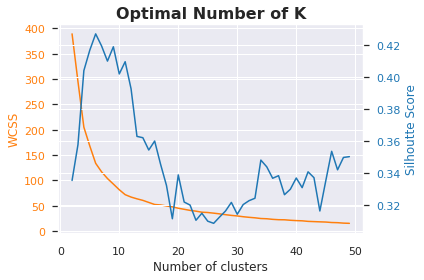

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics

# Elbow Method
k_range = [i for i in range (2, 50)]
wcss = []
silhouette = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=0)
    km_cluster = kmeans.fit_predict(feature)
    km_silhouette = metrics.silhouette_score(feature, km_cluster)

    wcss.append(kmeans.inertia_)
    silhouette.append(km_silhouette)
    # print(k, km_silhouette)
  
# Visualize 
## Initialize plot
fig, ax1 = plt.subplots()

## Draw wcss line
color1 = 'tab:orange'
ax1.set_title('Optimal Number of K', fontsize=16, fontweight='bold')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS', color=color1)
ax1.plot(k_range, wcss, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

##  instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

## Draw silhouette score line
color2 = 'tab:blue'
ax2.set_ylabel('Silhoutte Score', color=color2)
ax2.plot(k_range, silhouette, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()

### Building Model

From the above plot we can see that $k = 6$ get the best wcss score while also having a pretty good silhouette score so we will use it to build our model.

In [9]:
from sklearn import metrics

# Fit K-Means Model to the Data
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=500, n_init=10, random_state=0)
km_cluster = kmeans.fit_predict(feature)

# Evaluate model
km_silhouette = metrics.silhouette_score(feature, km_cluster)

## Hierarchical Clustering

Hierarchical clustering algorithms fall into 2 categories: top-down or bottom-up. Bottom-up algorithms treat each data point as a single cluster at the outset and then successively merge (or agglomerate) pairs of clusters until all clusters have been merged into a single cluster that contains all data points. Bottom-up hierarchical clustering is therefore called hierarchical agglomerative clustering or HAC. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

<div align='center'><img src='https://miro.medium.com/max/700/1*ET8kCcPpr893vNZFs8j4xg.gif' height='250'></div>

Advantages:
* Do not have to assume any particular number of clusters
* They may correspond to meaningful taxonomies

Disadvantages:
* Once a decision is made to combine two clusters, it cannot be undone
* No objective function is directly minimized
* Different schemes have problems with one or more of the following: (a) sensitivity to noise and outliers; (b) difficulty handling different sized clusters and convex shapes; (c) breaking large clusters

### Finding Optmimum Number of Cluster

The `AgglomerativeClustering()` function from sklearn allow us to define the number of cluster we want to obtain similar to the K-Means algorithm by providing the `n_cluster` parameter on the model. With this we can find the optimal number of cluster same as before by calculating the silhouette of each model and plotting it into a line graph.

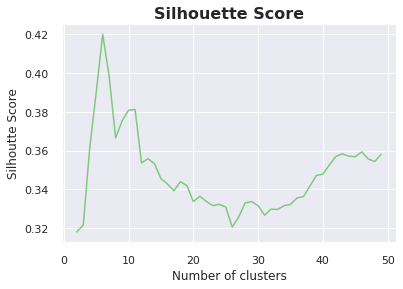

In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

k_range = [i for i in range (2, 50)]
# wcss = []
silhouette = []
for k in k_range:
    hc = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    hc_cluster = hc.fit_predict(feature)
    hc_silhouette = metrics.silhouette_score(feature, hc_cluster)

    # wcss.append(kmeans.inertia_)
    silhouette.append(hc_silhouette)
    # print(k, hc_silhouette)
  
# Visualize 
plt.plot(k_range, silhouette)
plt.title('Silhouette Score', fontsize=16, fontweight='bold')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte Score')
plt.show()

### Building Model

Turns out we also got 6 as the optimal number of cluster with the Agglomerative Hierarchical algorithm, so let's build our model with 6 clusters.

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

# Fit the Hierarchical Clustering Model to the Dataset
hc = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
hc_cluster = hc.fit_predict(feature)

# Evaluate model
hc_silhouette = metrics.silhouette_score(feature, hc_cluster)

## Model Comparison

Looking at the silhouette score of the best model from each algorithm we can see that they are about the same with K-Means having about 0.006 point higher than the hierarchical clustering.

In [12]:
print('Slhouette score of K-Means model:', km_silhouette)
print('Slhouette score of Agglomerative model:', hc_silhouette)

Slhouette score of K-Means model: 0.4268547747113388
Slhouette score of Agglomerative model: 0.4201169558789579


# Analysis

We will now try to visualize our cluster into a 3D plot to analyze the characteristic of each cluster.

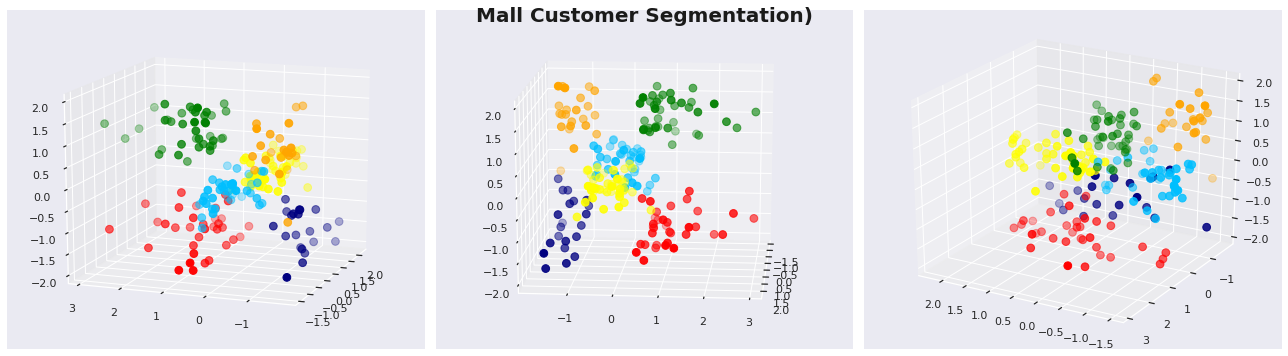

In [13]:
# Insert label into original data
feature['cluster'] = km_cluster

# Create figure
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# Define colors
colors = ['red', 'orange', 'yellow', 'green', 'deepskyblue', 'navy', 'purple']

axes = [ax1, ax2, ax3]
for ax in axes:
    # Iterate thorough each cluster
    for c in set(km_cluster):
        new_feature = feature[feature['cluster']==c]
        # plt.rcParams['axes.facecolor']='white'
        ax.scatter(new_feature['Age'], new_feature['Annual Income (k$)'], new_feature['Spending Score (1-100)'], c=colors[c], s=60)

ax1.view_init(elev=15, azim=-160)
ax2.view_init(elev=15, azim=5)
ax3.view_init(elev=25, azim=120)
fig.suptitle('Mall Customer Segmentation)', fontsize=20, color='k', fontweight='bold')

fig.tight_layout()

The visualization result show that our model did a pretty good job at clustering the data. Below are a couple simpler 2D graph to better help us understand our result.

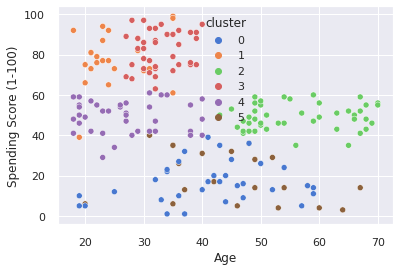

In [14]:
# Insert label into original data
df_mall['cluster'] = km_cluster

sns.scatterplot(data=df_mall, x='Age', y='Spending Score (1-100)', hue='cluster', palette='muted')

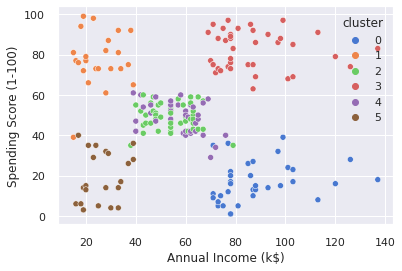

In [15]:
sns.scatterplot(data=df_mall, x='Annual Income (k$)', y='Spending Score (1-100)', hue='cluster', palette='muted')

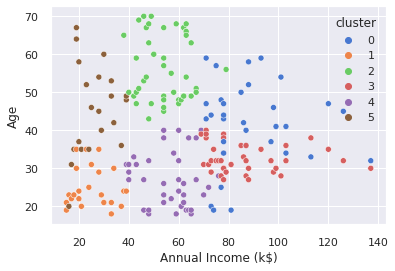

In [16]:
sns.scatterplot(data=df_mall, x='Annual Income (k$)', y='Age', hue='cluster', palette='muted')

Below are the 6 cluster we found and each of their characteristics:

* Cluster 0 (blue): all ages, have annual income more than \$70k, have low spending score (less than 40)
* Cluster 1 (orange): below 40 years old, have annual income less than \$40k, have above average spending score (more than 40)
* Cluster 2 (green): above 40 years old, have annual income between \$40k-\$70k, have average spending score (between 30-60)
* Cluster 3 (red): between 30-40 years old, have annual income more than \$70k, have high spending score (more than 60)
* Cluster 4 (purple): below 40 years old, have annual income between \$40k-\$80k, have average spending score (between 30-60)
* Cluster 5 (brown): all ages, have annual income less than \$40k, have low spending score (less than 40)

# Output

## Saving Clustering Result

Last, we will save our new dataset which include the cluster label into a csv file for easier access in the future.

In [17]:
# Save new dataframe into csv file
df_mall.to_csv('mall_customer_segmentation.csv', index=False)

df_mall.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,5
3,Female,23,16,77,1
4,Female,31,17,40,5


## Saving model

We can save our model for further model reusability. This model can then be loaded on another machine to make new prediction without doing the whole training process again.

In [18]:
from joblib import dump, load

# Saving model
dump(kmeans, 'mall_customer_segmentation.joblib')

# Loading model
# clf = load('bank_deposit_classification.joblib') 

['mall_customer_segmentation.joblib']

# Conclusion

For a simple model we can see that our model did pretty good at clustering the mall customer based on their age, annual income, and spending score. But there are still some weakness on our model, as shown on the visualization where there are still some intersecting clusters. We also got silhouette score of about 0.426 which support the previous statement and show that our model is still far from perfect. This can be solved by getting more information about the characteristics of the mall's customer (adding feature) or just by surveying more customer (adding more data).

# References

1. Telkom Digital Talent Incubator - Data Scientist Module 6 (Clustering)
2. [Scikit-learn Documentation](https://scikit-learn.org/stable/index.html)
3. [The 5 Clustering Algorithms Data Scientists Need to Know](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)